# Вводная часть

<b>Задача:</b>
Разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

<b>Метрика:</b> F1 (micro).

<b>Данные:</b>
- `train.csv` - информация (40000) музыкальных треках, которые будут использоваться в качестве обучающих данных.
- `test.csv` - информация (10000) музыкальных треках, которые будут использоваться в качестве тестовых данных.

<b>Описание полей данных:</b>

- `instance_id` -Уникальный идентификатор трека
- `track_name` - Название трека
- `popularity` - Популярность трека
- `acousticness` - Мера уверенности от 0,0 до 1,0 в том, что трек является акустическим. 1,0 означает высокую степень уверенности в том, что трек является акустическим.
- `danceability` - Танцевальность описывает, насколько трек подходит для танцев, основываясь на сочетании музыкальных элементов, включая темп, стабильность ритма, силу ударов и общую регулярность. Значение 0,0 означает наименьшую танцевальность, а 1,0 - наибольшую танцевальность.
- `duration_ms` - Продолжительность трека в миллисекундах.
- `energy` - Энергия это показатель от 0,0 до 1,0, представляющий собой меру интенсивности и активности. Как правило, энергичные композиции ощущаются как быстрые, громкие и шумные. Например, дэт-метал обладает высокой энергией, в то время как прелюдия Баха имеет низкую оценку этого параметра
- `instrumentalness` - Определяет, содержит ли трек вокал. Звуки "Ooh" и "aah" в данном контексте рассматриваются как инструментальные. Рэп или разговорные треки явно являются "вокальными". Чем ближе значение инструментальности к 1,0, тем больше вероятность того, что трек не содержит вокала
- `key` - базовый ключ (нота) произведения
- `liveness` - Определяет присутствие аудитории в записи. Более высокие значения liveness означают увеличение вероятности того, что трек был исполнен вживую. Значение выше 0,8 обеспечивает высокую вероятность того, что трек исполняется вживую
- `loudness` - Общая громкость трека в децибелах (дБ)
- `mode` - Указывает на модальность (мажорную или минорную) трека
- `speechiness` - Речевой характер определяет наличие в треке разговорной речи. Чем более исключительно речевой характер носит запись (например, ток-шоу, аудиокнига, поэзия), тем ближе значение атрибута к 1,0. Значения выше 0,66 характеризуют треки, которые, вероятно, полностью состоят из разговорной речи. Значения от 0,33 до 0,66 характеризуют треки, которые могут содержать как музыку, так и речь, как в виде фрагментов, так и в виде слоев, включая такие случаи, как рэп-музыка. Значения ниже 0,33, скорее всего, представляют музыку и другие неречевые треки.
- `tempo` - Темп трека в ударах в минуту (BPM). В музыкальной терминологии темп представляет собой скорость или темп данного произведения и напрямую зависит от средней продолжительности тактов
- `obtained_date` - дата загрузки в сервис
- `valence` - Показатель от 0,0 до 1,0, характеризующий музыкальный позитив, передаваемый треком. Композиции с высокой валентностью звучат более позитивно (например, радостно, весело, эйфорично), а композиции с низкой валентностью - более негативно (например, грустно, депрессивно, сердито)
- `music_genre` - Музыкальный жанр трека

# План
* загрузка и ознакомление с данными
* предварительная обработка
* полноценный разведочный анализ,
* разработка новых синтетических признаков,
* проверка на мультиколлинеарность,
* отбор финального набора обучающих признаков,
* выбор и обучение моделей,
* итоговая оценка качества предсказания лучшей модели,
* анализ важности ее признаков.

# Библиотеки

In [1]:
import warnings
warnings.filterwarnings('ignore')
# библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
import phik
from phik import resources, report
from sklearn.feature_selection import SelectKBest#, chi2
import numpy as np

# Этап 1. Загрузка и проверка данных.

Загрузка данных из файлов.

In [2]:
df_train = pd.read_csv('./music-genre-prediction-m127ds/train.csv')
df_test = pd.read_csv('./music-genre-prediction-m127ds/test.csv')

Обзор данных train.

In [3]:
df_train.head()

,instance_id,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,4919,By Your Side,33.0,0.000718,0.501,-1.0,0.935,0.020100,G#,0.0831,-5.566,Minor,0.1570,144.922,4-Apr,0.1880,Electronic
1,16096,NaN,55.0,0.064700,0.282,288333.0,0.738,0.014200,C,0.2900,-5.566,Major,0.0324,126.914,NaN,0.2110,Alternative
2,43825,Symphony No. 6: VI. Allegro,39.0,0.931000,0.364,115240.0,0.349,0.940000,NaN,0.1100,-13.279,NaN,0.0321,65.42699999999999,4-Apr,0.0891,Classical
3,4331,NaN,56.0,0.012300,0.332,234638.0,0.847,0.000027,B,0.2970,-4.513,Minor,0.0910,67.23,5-Apr,0.3920,Electronic
4,21371,Shoe Shopping,52.0,0.580000,0.716,221640.0,0.614,0.000014,G,0.1600,-7.099,Major,0.0360,88.006,4-Apr,0.6800,Country


Обзор данных test.

In [4]:
df_test.head()

,instance_id,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
0,20514,Bullet Proof ... I Wish I Was,49.0,0.7800,0.448,208733.0,0.359,0.671000,G,0.0753,-13.559,Major,0.0288,80.91199999999999,4-Apr,0.0773
1,46957,Does It,48.0,0.2120,0.651,262547.0,0.655,0.000198,A,0.2060,-9.430,NaN,0.1650,120.10799999999999,4-Apr,0.2710
2,5488,NaN,34.0,0.1630,0.595,270733.0,0.277,0.677000,C#,0.1310,-14.141,Major,0.0391,153.464,3-Apr,0.1450
3,18150,Breaking Inside (feat. Lzzy Hale of Halestorm),41.0,0.0684,0.466,227467.0,0.912,0.000000,D,0.0892,-3.423,Minor,0.0474,151.977,4-Apr,0.4160
4,20148,NaN,47.0,0.0012,0.345,298813.0,0.974,0.000030,D,0.3620,-3.221,Minor,0.0607,175.02700000000002,4-Apr,0.5710


Изучение датафрейма train методом .info()

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       40000 non-null  int64  
 1   track_name        29262 non-null  object 
 2   popularity        36078 non-null  float64
 3   acousticness      40000 non-null  float64
 4   danceability      37963 non-null  float64
 5   duration_ms       40000 non-null  float64
 6   energy            40000 non-null  float64
 7   instrumentalness  40000 non-null  float64
 8   key               38577 non-null  object 
 9   liveness          40000 non-null  float64
 10  loudness          40000 non-null  float64
 11  mode              38147 non-null  object 
 12  speechiness       40000 non-null  float64
 13  tempo             40000 non-null  object 
 14  obtained_date     33781 non-null  object 
 15  valence           40000 non-null  float64
 16  music_genre       40000 non-null  object

Изучение датафрейма test методом .info()

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       10000 non-null  int64  
 1   track_name        7388 non-null   object 
 2   popularity        8987 non-null   float64
 3   acousticness      10000 non-null  float64
 4   danceability      9477 non-null   float64
 5   duration_ms       10000 non-null  float64
 6   energy            10000 non-null  float64
 7   instrumentalness  10000 non-null  float64
 8   key               9673 non-null   object 
 9   liveness          10000 non-null  float64
 10  loudness          10000 non-null  float64
 11  mode              9518 non-null   object 
 12  speechiness       10000 non-null  float64
 13  tempo             10000 non-null  object 
 14  obtained_date     8419 non-null   object 
 15  valence           10000 non-null  float64
dtypes: float64(10), int64(1), object(5)
memor

describe таблицы df_train: только числовые признаки.

In [7]:
df_train.drop(columns=['instance_id']).describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,valence
count,36078.000000,40000.000000,37963.000000,4.000000e+04,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,44.180969,0.307544,0.558330,2.213221e+05,0.598456,0.182680,0.193490,-11.682016,0.129375,0.456093
std,15.550792,0.342142,0.179047,1.297367e+05,0.265156,0.326242,0.161448,14.426354,0.212147,0.247108
min,0.000000,0.000000,0.060000,-1.000000e+00,0.000795,0.000000,0.009670,-110.951000,0.022300,0.000000
25%,34.000000,0.020300,0.442000,1.748498e+05,0.430000,0.000000,0.096800,-11.617250,0.036400,0.257000
50%,45.000000,0.145000,0.569000,2.193200e+05,0.641000,0.000163,0.126000,-7.480000,0.050100,0.447000
75%,56.000000,0.554000,0.687000,2.686670e+05,0.815000,0.159000,0.242000,-5.258000,0.113000,0.648000
max,99.000000,0.996000,0.980000,4.830606e+06,0.999000,0.993000,1.000000,3.744000,1.820000,0.992000


describe таблицы df_train: только категориальные признаки.

In [8]:
df_train.describe(include = 'object')

,track_name,key,mode,tempo,obtained_date,music_genre
count,29262,38577,38147,40000,33781,40000
unique,26018,12,2,25110,5,10
top,Home,G,Major,?,4-Apr,Rock
freq,11,4404,24593,3979,30243,4055


Гистограммы по всем числовым признакам.

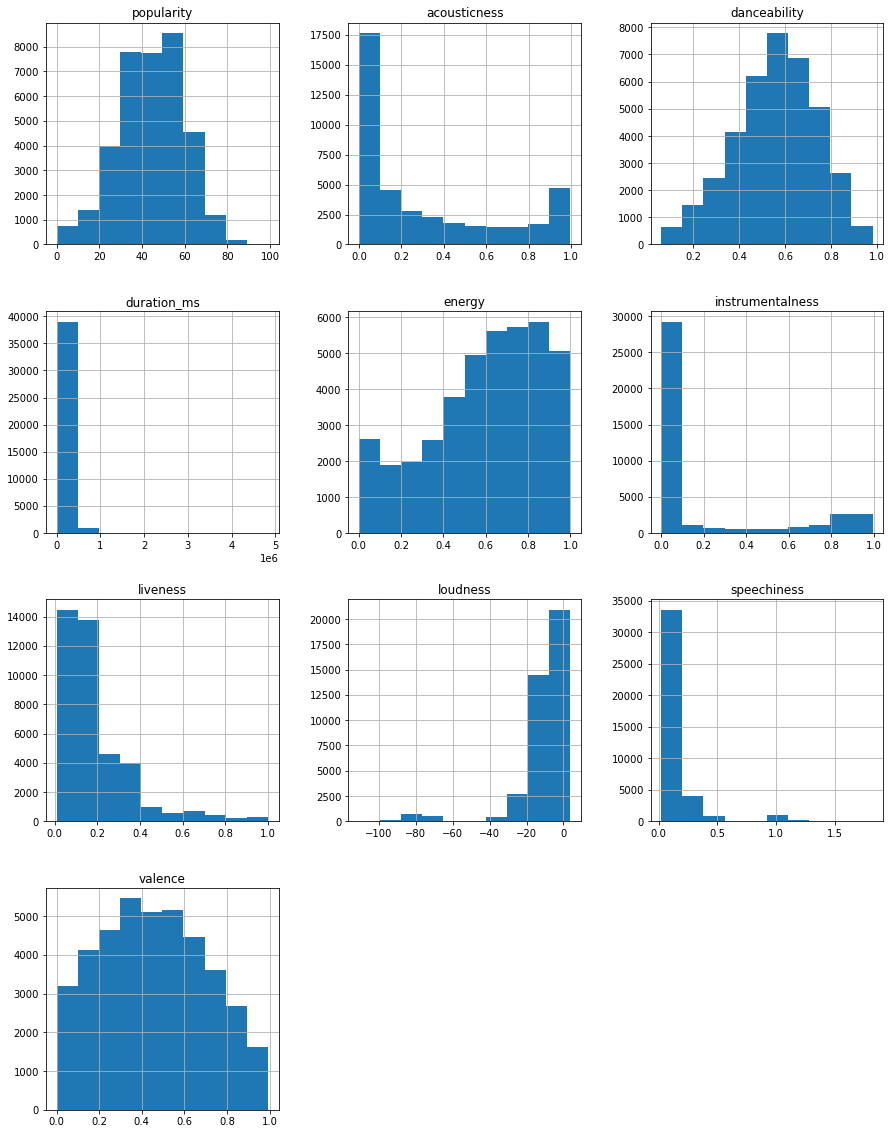

In [9]:
ax = df_train.drop(columns=['instance_id']).hist(figsize=(15,20))
plt.show()

<b>Выводы по этапу:</b>
* Есть NA значения в столбцах `track_name`, `popularity`, `danceability`, `key`, `mode`, `obtained_date` в датафреймах df_train и df_test (по выводу info).
* Столбцы `tempo`и `obtained_date` имею тип object, хотя содержат количественные значения и дату (по выводу info).
* В столбце `tempo` самое часто встречающееся значение "?". Возможно, так заполнены пропуски (по выводу describe).
* В столбце `obtained_date` часто встречающееся значение "4-Apr". 3/4 песен в df_train залита в одно время? (по выводу describe).
* В столбце `duration_ms` есть значение -1.
* В столце `loudness` стоят отрицательные значения, хотя признак содержит громкость в дБ (по гистограмме).
* В столбце `speechiness` значения > 1, что возможно противоречит описанию данных: "Чем более исключительно речевой характер носит запись (например, ток-шоу, аудиокнига, поэзия), тем ближе значение атрибута к 1,0.", хотя в явном виде ограничение сверху не накладывается.
* Признак `speechiness` противоречит признаку `instrumentalness`, т.к. последний указывает на то, что вокальных треков большинство, а `speechiness`, наоборот, указывает, что большинство треков без слов или с небольшим количеством слов.


# Этап 2. Предобработка.

Фиксация размера датафрейма до предобработки и создание словаря с причинами и количеством удаленных строк.

In [10]:
df_train_before_count = df_train.shape
delete_rows_reasons = {}

 Проверка на явные дубликаты.

In [11]:
df_train.duplicated().sum()

0

Проверка на неявные дубликаты. Выделяю строки, у которых есть неявные дупликаты и сами эти строки. Предполагается, что `acousticness`,`speechiness`,`instrumentalness`,`duration_ms`,`loudness` определяют песню однозначно. Эти признаки не содержат NA и являются количетвенными.

In [12]:
df_train[['acousticness','speechiness','instrumentalness','duration_ms','loudness']].duplicated(keep
 =False).sum()

3844

Таких строк 3844. Рассмотрим несколько:

In [13]:
# отбор
idx_to_drop = df_train[['acousticness','speechiness','instrumentalness','duration_ms','loudness']].duplicated(keep
 =False)
# вывод
df_train[idx_to_drop][5:10].sort_values(by='track_name')

,instance_id,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
67,30433,I'm Real - Murder Remix,53.0,0.4120,0.706,252933.0,0.624,0.0,B,0.139,-5.978,Minor,0.1300,83.506,4-Apr,0.563,Rap
69,28660,Poetic Justice,69.0,0.1570,0.779,300160.0,0.572,0.0,F#,0.246,-9.985,Minor,0.3780,135.95600000000002,4-Apr,0.647,Rap
53,38169,Somebody's Got Me,54.0,0.0306,0.638,204498.0,0.729,0.0,A#,0.124,-4.366,Major,0.0353,143.963,NaN,0.589,Rock
45,40551,The Devil Went Down to Georgia,63.0,0.1310,0.517,215067.0,0.535,0.0,C,0.085,-12.027,Major,0.0494,135.08700000000002,4-Apr,0.933,Rock
64,48639,NaN,53.0,0.1080,0.752,222653.0,0.856,0.0,D,0.745,-5.833,Major,0.2330,103.741,4-Apr,0.403,Hip-Hop


У песни с одними и теми же параметрами разные жанры. Это будет путать модель. Удалим эти строки.

In [14]:
df_train = df_train[~idx_to_drop]
delete_rows_reasons['Удаление неявных дупликатов'] = idx_to_drop.sum()

Проврека.

In [15]:
# проверка записи
print('запись :')
display(delete_rows_reasons)
print('info : \n')
# проверка изменения
df_train.info()


запись :


{'Удаление неявных дупликатов': 3844}

info : 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36156 entries, 0 to 39999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       36156 non-null  int64  
 1   track_name        26501 non-null  object 
 2   popularity        32597 non-null  float64
 3   acousticness      36156 non-null  float64
 4   danceability      34310 non-null  float64
 5   duration_ms       36156 non-null  float64
 6   energy            36156 non-null  float64
 7   instrumentalness  36156 non-null  float64
 8   key               34878 non-null  object 
 9   liveness          36156 non-null  float64
 10  loudness          36156 non-null  float64
 11  mode              34473 non-null  object 
 12  speechiness       36156 non-null  float64
 13  tempo             36156 non-null  object 
 14  obtained_date     30565 non-null  object 
 15  valence           36156 non-null  float64
 16  music_genre       36156 non-nul

Обработаем столбец `tempo`, который имеет тип object, хотя содержит количетвенную информацию и символ "?".
Количество строк с сисволом "?":

In [16]:
display(df_train.loc[df_train['tempo'] == '?',['tempo']].count())
df_test.loc[df_test['tempo'] == '?',['tempo']].count()

tempo    3615
dtype: int64

tempo    1001
dtype: int64

Преобразование столбца в "float64". Дублируем действия сразу и в train, и в test. Это будет делаться по умолчанию и далее (кроме удаления строк).

In [17]:
# train
df_train['tempo'] = pd.to_numeric(df_train['tempo'], errors='coerce')
# test
df_test['tempo'] = pd.to_numeric(df_test['tempo'], errors='coerce')

In [18]:
# проверка типов
display(df_train['tempo'].dtype)
df_test['tempo'].dtype

dtype('float64')

dtype('float64')

Проверка количества NA в поле (должно совпасть с числом "?" до изменений).

In [19]:
display(df_train['tempo'].isna().sum())
df_test['tempo'].isna().sum()

3615

1001

Небольшая часть данных идет со значением loudness > 0, остальная со значением < 0.

In [20]:
# >=0
display(df_train[df_train['loudness']>=0].shape[0])
# <0
df_train[df_train['loudness']<0].shape[0]

37

36119

Исправим значение громкости на положительное для всех треков.

In [21]:
# train
df_train['loudness'] = abs(df_train['loudness'])
# test
df_test['loudness'] = abs(df_test['loudness'])

Проверка.

In [22]:
df_train['loudness'].min()

0.0

Проверка столбцов key и mode с типом данных object.

In [23]:
print('Различные значения в key')
df_train['key'].unique()

Различные значения в key


array(['G#', 'C', nan, 'B', 'G', 'D', 'E', 'C#', 'A', 'F', 'A#', 'F#',
       'D#'], dtype=object)

Количество NaN в столбце.

In [24]:
df_train['key'].isna().sum()

1278

In [25]:
print('Различные значения в mode')
df_train['mode'].unique()

Различные значения в mode


array(['Minor', 'Major', nan], dtype=object)

Количество NaN в столбце.

In [26]:
df_train['mode'].isna().sum()

1683

В ходе анализа не удалось установить зависимость заполнения полей `mode` и `key` от других столбцов. Решено заполнить пропуски значением "noinfo" - нет данных, добавив таким образом новое значение в каждый столбец.

In [27]:
# train
df_train['mode'] = df_train['mode'].fillna('noinfo')
df_train['key'] = df_train['key'].fillna('noinfo')
# test
df_test['mode'] = df_test['mode'].fillna('noinfo')
df_test['key'] = df_test['key'].fillna('noinfo')

Проверка

In [28]:
df_train['mode'].value_counts()

Major     22267
Minor     12206
noinfo     1683
Name: mode, dtype: int64

In [29]:
df_train['mode'].isna().sum()

0

In [30]:
df_train['key'].value_counts()

G         4046
C         3897
C#        3664
D         3656
A         3398
F         3049
E         2638
B         2637
G#        2322
A#        2299
F#        2176
noinfo    1278
D#        1096
Name: key, dtype: int64

In [31]:
df_train['key'].isna().sum()

0

<b>Выводы по этапу:</b>
* Явные дубли не обнаружены.
* Выявлены неявные дубликаты. Т.к. у дублей разные значения жанров, то принято решение удалить как дубли, так и оригинальные строки, т.к. отличить одно от другого технически сложно).
* Столбец `tempo` преобразован в тип float64, значения "?" преобразованы в NaN.
* В столбце `loudness` отрицательные значения преобразованы в положительные.
* В столбцах `mode` и `key` пропуски заменены на значения noinfo, т.к. установить взаимосвязть с другими параметрами не удается.
* Количественные признаки с пропусками `tempo` и `danceability` будут исправлены в процессе EDA, т.к. для их заполнения требуется дополнительный анализ.
* Признак `speechiness` будет исследован на корректность в процессе EDA. Значения > 1 могут быть скорректированы на том же этапе.
* Признаки `instance_id`, `track_name`,`obtained_date` не исследовались и не корректировались, т.к. не будут участвовать в обучении модели. Они будут удалены в процессе подготовки данных к обучению.

In [32]:
# итого корректировки 
print('Число строк до предобработки в train: ', df_train_before_count[0])
print('Число строк после предобработкии\ в train: ', df_train.shape[0])
print(f'Доля потерянных данных:  {1-df_train.shape[0]/df_train_before_count[0]:.2%}')
print('Причины удаления данных:')
print(delete_rows_reasons)

Число строк до предобработки в train:  40000
Число строк после предобработкии\ в train:  36156
Доля потерянных данных:  9.61%
Причины удаления данных:
{'Удаление неявных дупликатов': 3844}


# Этап 3. EDA и заполнение пропусков.

### Целевой признак `music_genre`:

Построим гистограмму распределения признака.

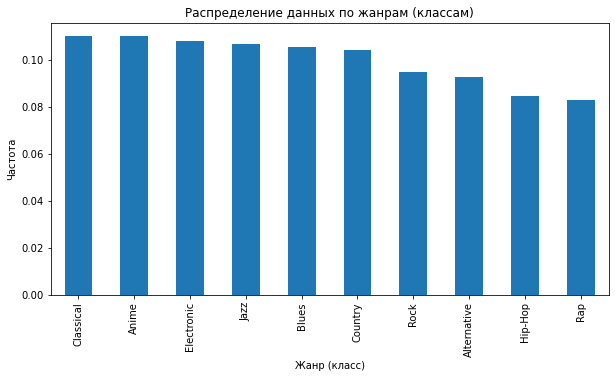

In [33]:
(
df_train['music_genre']
    .value_counts(normalize=True)
    .plot(kind='bar', figsize=(10,5),
          title='Распределение данных по жанрам (классам)',
          xlabel='Жанр (класс)', ylabel='Частота')
)
plt.show()

Всего 10 классов. В данных нет дисбаланса: доля каждого класса от 8% до 11%. Методы для борьбы с дисбалансом применять не нужно.

### Признак `popularity`:

Построим гистограмму распределения признака.

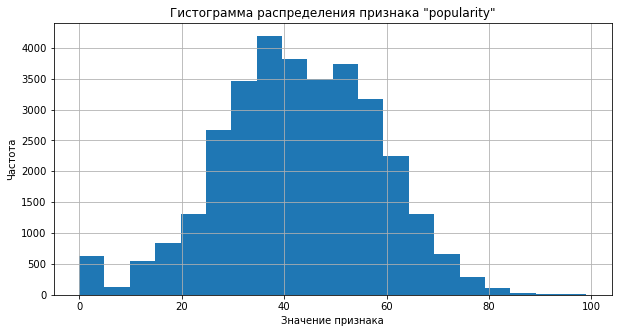

In [34]:

ax = (df_train['popularity']
    .plot(kind='hist', bins=20, figsize=(10,5),
          title='Гистограмма распределения признака "popularity"',
          grid=True)
)
ax.set_xlabel('Значение признака')
ax.set_ylabel('Частота')
plt.show()

Видно, что ближе к 0 есть столбец с 600 треками. Рассмотрим их жанры:

In [35]:
df_train.loc[df_train['popularity']<5,'music_genre'].value_counts()

Classical      458
Jazz            51
Blues           29
Country         28
Anime           26
Electronic      23
Rock             4
Alternative      3
Name: music_genre, dtype: int64

По большей части это классическая музыка. Чуть шире интервал:

In [36]:
df_train.loc[df_train['popularity']<20,'music_genre'].value_counts()

Anime          1308
Classical       619
Jazz             73
Blues            48
Country          30
Electronic       25
Rock              6
Alternative       6
Rap               2
Hip-Hop           1
Name: music_genre, dtype: int64

Добавляется музыка в жанре аниме. Для треков со значением популярности выше 70 распределение такое:

In [37]:
df_train.loc[df_train['popularity']>=70,'music_genre'].value_counts()

Rap            411
Rock           315
Hip-Hop        264
Country         48
Alternative     37
Electronic      11
Blues            6
Jazz             3
Name: music_genre, dtype: int64

Преобладает рэп и хип хоп. Признак будет полезен в дальнейшем.

! Странно, что популярность так влияет, т.к. это очень субъективная вещь. Но почему-то он показывается высокую корреляию с целевой переменной (далее).

В признаке есть пропуски. Заполнение пропусков будет выполнено в конце исследования после изучения прочих признаков.

### Признак `acousticness`:

Построим гистограмму распределения признака.

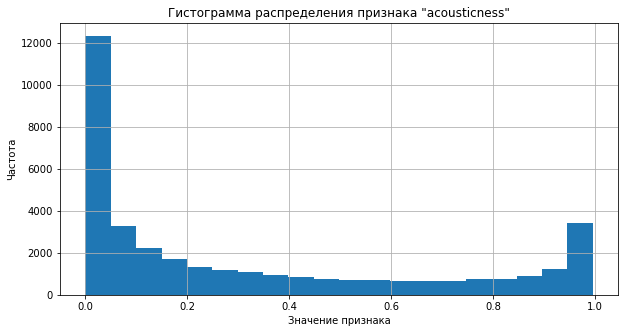

In [38]:

ax = (df_train['acousticness']
    .plot(kind='hist', bins=20, figsize=(10,5),
          title='Гистограмма распределения признака "acousticness"',
          grid=True)
)
ax.set_xlabel('Значение признака')
ax.set_ylabel('Частота')
plt.show()

На гистограмме следует отметить следующее:
* примерно 1/3 треков имеет значение этого признака от 0 до 0.05, т.е. вероятность их аккустичности не более 5 процентов;
* примерно 9% треков имеют высокую вероятность акустичности - группа от 0.95 до 1.

Рассмотрим эт две группы подробнее:

In [39]:
df_train[df_train['acousticness']>0.95].value_counts(subset=['music_genre'])

music_genre
Classical      2429
Anime           367
Jazz            339
Blues            95
Rock             19
Country          13
Electronic       13
Alternative       7
Hip-Hop           4
dtype: int64

Большая часть треков со значением признака > 0.95 в категории "Классическая музыка".

In [40]:
df_train[df_train['acousticness']<=0.05].value_counts(subset=['music_genre'])

music_genre
Electronic     2380
Anime          1853
Alternative    1810
Rock           1524
Blues          1048
Rap            1031
Country         978
Hip-Hop         964
Jazz            521
Classical       250
dtype: int64

Большая часть треков со значением <=0.05 в категории "Электронная музыка". Звук скорее всего генерируется искуственно, а не записывается вживую. Немного странным выглядит наличие классической музыки в этом списке.

<ins>Вывод</ins>: признак acousticness вполне адекватно себя ведет в привязке к жанрам. Его стоит использовать в модели.

### Признак `danceability`:

Построим гистограмму распределения признака.

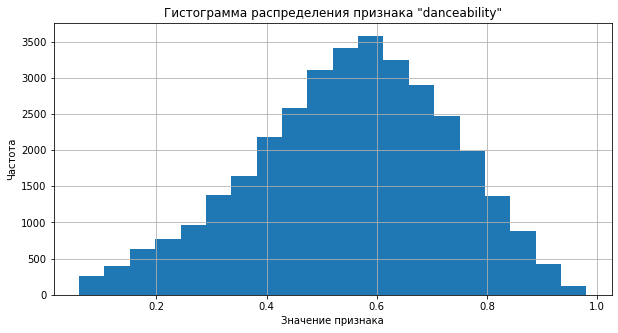

In [41]:
ax =(df_train['danceability']
     .plot(kind='hist', bins=20,figsize=(10,5),
           title='Гистограмма распределения признака "danceability"',
           grid=True)
)
ax.set_xlabel('Значение признака')
ax.set_ylabel('Частота')
plt.show()
plt.show()

Распределение признака имеет форму, близкую к нормальному, с небольшим скосом влево. В столбце есть пропуски, которые необходимо устранить. Проверим признак на адекватность.

In [42]:
df_train[df_train['danceability']<0.1].value_counts(subset=['music_genre'])

music_genre
Classical      192
Anime           24
Alternative      1
Electronic       1
Jazz             1
Rock             1
dtype: int64

Классическая музыка не считается танцевальной. В этой части признак адекватен.

In [43]:
df_train[df_train['danceability']>0.9].value_counts(subset=['music_genre'])

music_genre
Rap            139
Hip-Hop        138
Electronic      46
Jazz            27
Alternative     14
Blues           11
Country          6
Anime            1
Rock             1
dtype: int64

Hip-hop и Rap вполне ритмичная музыка. В этой части признак адекватен.

### Признак `duration_ms`:

Построим гистограмму распределения признака.

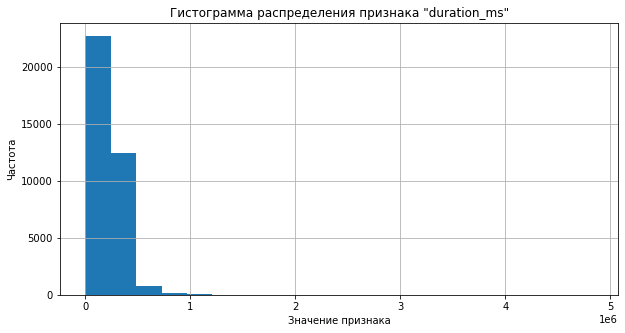

In [44]:
ax =(df_train['duration_ms']
     .plot(kind='hist', bins=20,figsize=(10,5),
           title='Гистограмма распределения признака "duration_ms"',
           grid=True)
)
ax.set_xlabel('Значение признака')
ax.set_ylabel('Частота')
plt.show()
plt.show()   

Шкала по оси x получилась очень вытянутая, возможны выбросы. Рассмотрим boxplot с ограничением до 1 млн.м.с., т.к. при построении графика без ограничений основные показатели boxplot просто не видны:

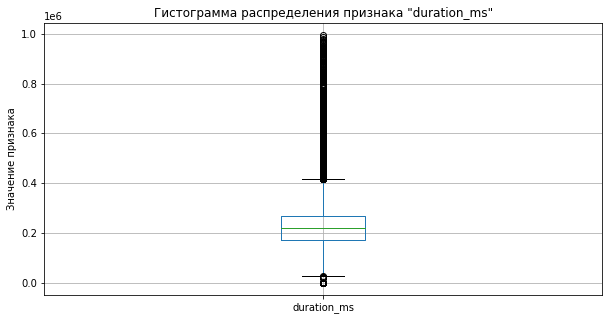

In [45]:
ax =(df_train.query('duration_ms < 1_000_000')['duration_ms']
     .plot(kind='box',figsize=(10,5),
           title='Гистограмма распределения признака "duration_ms"',
           grid=True)
)
ax.set_ylabel('Значение признака')
plt.show()

Здесь стоит выделить те участки, которые отмечены как выбросы: значения, близкие к 0, и значения свыше 400 000 м.с. (примерно 6.5 минут).

Рассмотрим часть треков с продолжительностью с продолжительность >= 400 000 миллисекунд:

Количество:

In [46]:
df_train.query('duration_ms >= 400_000')['instance_id'].count()

1947

Гистограмма:

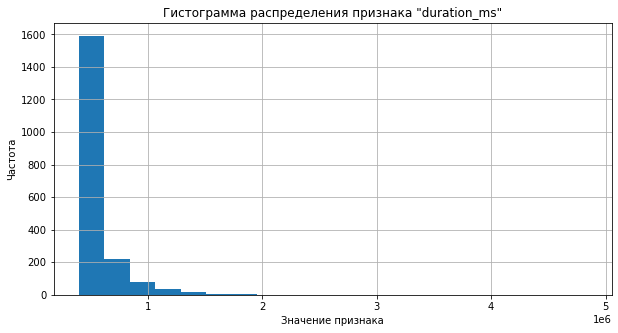

In [47]:
ax =(df_train.query('duration_ms >= 400_000')['duration_ms']
     .plot(kind='hist', bins=20,figsize=(10,5),
           title='Гистограмма распределения признака "duration_ms"',
           grid=True)
)
ax.set_xlabel('Значение признака')
ax.set_ylabel('Частота')
plt.show()
plt.show()   

Таких треков достаточно много - прмиерно 2000 или 5% датасета. Сдвинем границу чуть вверх до 600 000 м.с. (примерно 10 минут).

In [48]:
df_train.query('duration_ms >= 600_000')['instance_id'].count()

386

Таких треков 386 или примерно 1%. 10 минут разумное время для большинства треков. Остальная часть обучающей выборки может искажать результат. Удалим ее:

In [49]:
# запись в словарь
delete_rows_reasons['Удаление выбросов в признаке duration_ms'] = df_train.query('duration_ms >= 600_000')['instance_id'].count()
# удаление
df_train = df_train.loc[df_train['duration_ms'] < 600000]

Новая гистограмма:

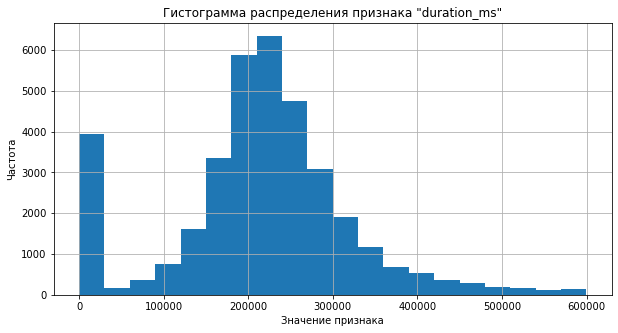

In [50]:
ax =(df_train['duration_ms']
     .plot(kind='hist', bins=20,figsize=(10,5),
           title='Гистограмма распределения признака "duration_ms"',
           grid=True)
)
ax.set_xlabel('Значение признака')
ax.set_ylabel('Частота')
plt.show()
plt.show()   

Столбец в районе 0 стало выделяться еще сильнее. Рассмотрим его:

In [51]:
df_train.query('duration_ms <= 0').head()

,instance_id,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,4919,By Your Side,33.0,0.000718,0.501,-1.0,0.935,0.020100,G#,0.0831,5.566,Minor,0.1570,144.922,4-Apr,0.188,Electronic
19,12491,NaN,33.0,0.269000,0.580,-1.0,0.748,0.866000,C#,0.0777,7.736,Major,0.0307,97.258,4-Apr,0.762,Jazz
25,46065,Dreams,NaN,0.394000,0.490,-1.0,0.351,0.000008,B,0.1110,12.918,Minor,0.1940,82.127,1-Apr,0.316,Hip-Hop
27,48579,Sorry,55.0,0.428000,0.870,-1.0,0.531,0.000000,F,0.0798,6.471,Major,0.0992,NaN,NaN,0.315,Hip-Hop
31,19239,Dead Leaves And The Dirty Ground,46.0,0.471000,0.363,-1.0,0.611,0.000003,B,0.0735,4.215,Minor,0.0330,NaN,4-Apr,0.460,Alternative


Наличие 10% треков со значением признака -1 может быть проблемой при обучении. Есть несколько вариантов:
- придумать алгоритм расчета времени из имеющихся данных;
- удалить данные;
- заменить значения средним по какому-то параметру (например, tempo или любому другому коррелирующему с `duration_ms`);

Если выбрать:
- вариант 1, то не понятно, как это сделать. Технически, здесь может подойти только параметр `tempo`, который отвечает за ритм, но пока вариант кажется нереальным;
- вариант 2, то есть риск, что увидев эти данные в тестовой выборке, модель поведет себя неадекватно, хотя на кросс-валидации все было бы хорошо;
- вариант 3, то признак будет заполнен, а средние занчения не будут особо перекашивать модель.

Для начала заменим -1 на NaN:

In [52]:
# train
idx = (df_train['duration_ms'] <= 0)
df_train.loc[idx, 'duration_ms'] = np.nan
# test
idx = (df_test['duration_ms'] <= 0)
df_test.loc[idx, 'duration_ms'] = np.nan

Проверка:

In [53]:
df_train['duration_ms'].isna().sum()

3918

In [54]:
df_test['duration_ms'].isna().sum()

983

Итоговая обрабокта пропусков будет выполняться по варианту 3, т.к. она реализуема и видится наиболее качественной.

### Признак `energy`:

Построим гистограмму распределения признака.

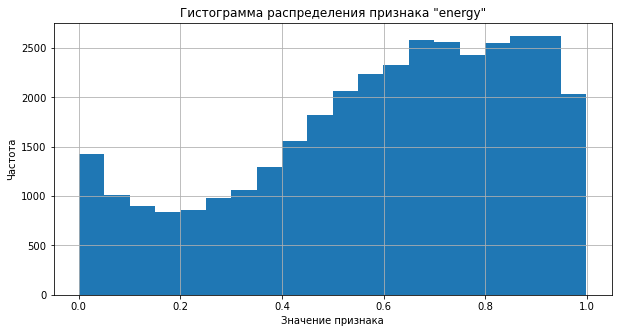

In [55]:
ax =(df_train['energy']
     .plot(kind='hist', bins=20,figsize=(10,5),
           title='Гистограмма распределения признака "energy"',
           grid=True)
)
ax.set_xlabel('Значение признака')
ax.set_ylabel('Частота')
plt.show()
plt.show()

В датасете преобладает энергичная музыка. Если разделить музыку на категории по значению параметра "до 0.35 - спокойная", "от 0.35 до 0.65 - нормальная" и "от 0.65 до 1 - энергичная", то видно, что энергичной музыки примерно в 2.5. раза больше, чем спокойной и примерно в 1.5 раза больше чем нормальной:

In [56]:
# расчет долей по категориям:
((df_train['energy'] < 0.35) * 1 + 
 ((0.35 <= df_train['energy']) & (df_train['energy'] < 0.65)) * 2 + 
 (df_train['energy'] >= 0.65) * 3).value_counts(normalize=True)

3    0.486218
2    0.316215
1    0.197568
Name: energy, dtype: float64

In [57]:
df_train[df_train['energy']>=0.9]['music_genre'].value_counts()

Anime          1273
Electronic      993
Alternative     790
Rock            470
Blues           369
Country         211
Classical       156
Rap             152
Hip-Hop         121
Jazz            115
Name: music_genre, dtype: int64

Признак хорошо отражает особенности жанров. Например, так выглядят гистограммы для треков с классческой музыкой и альтернативой (на одном графике).

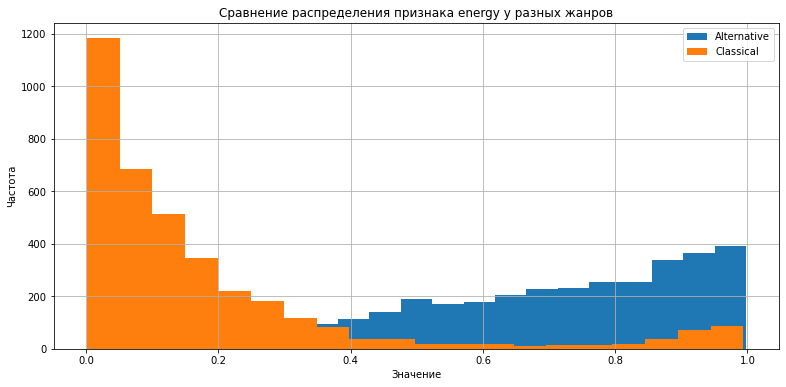

In [58]:
fig, ax = plt.subplots(figsize=(13,6))

ax.hist((df_train.query('music_genre=="Alternative"')['energy']), bins=20, label='Alternative')
ax.hist((df_train.query('music_genre=="Classical"')['energy']), bins=20, label='Classical')

ax.set_title('Сравнение распределения признака energy у разных жанров')
ax.set_xlabel('Значение')
ax.set_ylabel('Частота')
ax.grid()
plt.legend(loc='upper right')
ax.grid=True
plt.show()


Проверка адекватности:

Большая часть музыки со значением параметра <0.05 - классическая, что согласуется с описанием параметра.

Признак полезен при определении жанра. Также он может быть полезен при заполнении пропусков в других признаках, т.к. по этому показателю треки достаточно хорошо представлены в каждом интервале. Идея следующая:
1. Нарезать треки по этому признаку на интервалы. Например, [0 - 0.1),[0.1 - 0.2) ...., [0.9,1].
2. Рассчитать среднее или медиану признака, для которого хотим заполнить пропуски в разрезе этих интервало.
3. Заполнить пропуски.

! Хорошо, если признак коррелирует с тем, который хотим заполнить.

### Признак `instrumentalness`:

Построим гистограмму распределения признака.

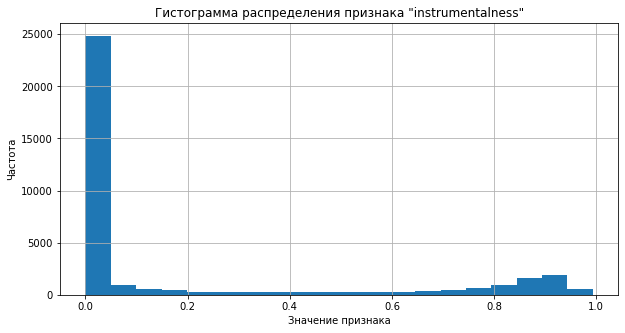

In [59]:
ax =(df_train['instrumentalness']
     .plot(kind='hist', bins=20,figsize=(10,5),
           title='Гистограмма распределения признака "instrumentalness"',
           grid=True)
)
ax.set_xlabel('Значение признака')
ax.set_ylabel('Частота')
plt.show()

Подавляющее большинство треков содержат вокал. Если считать треки со значением "до 0.35 - вокальными", "от 0.35 до 0.65 - промежуточными", "от 0.65 до 1 - почти без вокала", то распределение такое: 

In [60]:
# расчет долей по категориям:
((df_train['instrumentalness'] < 0.35) * 1 + 
 ((0.35 <= df_train['instrumentalness']) & (df_train['instrumentalness'] < 0.65)) * 2 + 
 (df_train['instrumentalness'] >= 0.65) * 3).value_counts(normalize=True)

1    0.774672
3    0.178362
2    0.046967
Name: instrumentalness, dtype: float64

Проверка адекватности:

In [61]:
df_train.loc[df_train['instrumentalness']>0.95,'music_genre'].value_counts()

Classical     148
Anime         140
Jazz           45
Electronic     38
Rock            5
Blues           5
Name: music_genre, dtype: int64

In [62]:
df_train.loc[df_train['instrumentalness']<0.05,'music_genre'].value_counts()

Country        3688
Hip-Hop        2949
Rock           2936
Blues          2933
Rap            2908
Alternative    2845
Anime          2457
Jazz           1751
Electronic     1545
Classical       835
Name: music_genre, dtype: int64

Большая часть треков "без слов" - классическая музыка, а в группе со значением параметра < 0.05 много разных жанров.
Отдельно рассматривается сегмент "Классической музыки" со значением параметра 0.05 и менее:

In [63]:
df_train.loc[(df_train['instrumentalness']<0.05)&(df_train['music_genre']=='Classical')].head()

,instance_id,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
62,44569,Perhaps Love,36.0,0.90600,0.367,179187.0,0.2150,0.000004,A,0.103,13.824,Major,0.0524,NaN,4-Apr,0.3600,Classical
88,44278,"Les contes d'Hoffmann, Act II: Entr'acte - Ell...",0.0,0.96400,NaN,NaN,0.0179,0.000092,A#,0.354,27.506,Major,0.0533,173.780,3-Apr,0.0346,Classical
90,43611,"Fidelio, Op. 72, Act I: Ihr könnt das leicht s...",0.0,0.75400,0.550,106013.0,0.0237,0.000000,C,0.244,38.267,Major,0.1420,NaN,3-Apr,0.2000,Classical
262,43609,"Rinaldo, HWV 7a, Act III (Ed. G. Sechi): La su...",NaN,0.97000,0.487,40704.0,0.1160,0.000000,noinfo,0.487,90.608,Major,0.4420,70.716,4-Apr,0.3650,Classical
270,42208,The Curse of Feanor - Remastered 2007,38.0,0.00206,0.463,341920.0,0.9850,0.046300,B,0.311,5.542,Major,0.1160,153.619,NaN,0.1120,Classical


Проверив пару произведений, можно сделать вывод, что такое сочетание возможно, если на заднем фоне поет хор. Признак адекватен.

### Признак `liveness`:

Построим гистограмму распределения признака.

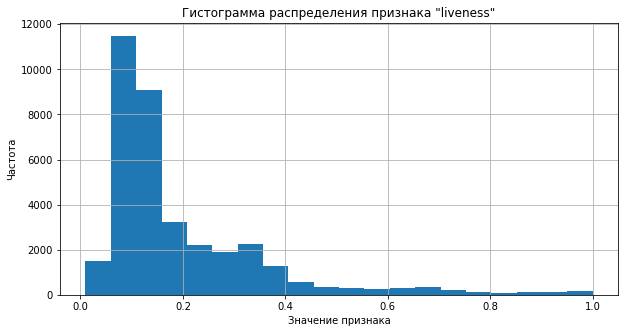

In [64]:
ax =(df_train['liveness']
     .plot(kind='hist', bins=20,figsize=(10,5),
           title='Гистограмма распределения признака "liveness"',
           grid=True)
)
ax.set_xlabel('Значение признака')
ax.set_ylabel('Частота')
plt.show()
plt.show()

Большинство песен записаны без присутствия аудитории (если определить таковыми треки со значением < 0.4).
Проверка того, что при значении 0.8 трек скорее всего записывали вживую:

In [65]:
df_train[df_train['liveness']>0.8].shape[0]

503

In [66]:
df_train[(df_train['liveness']>0.8)
         &(~df_train['track_name'].isna())
         &(df_train['track_name'].str.lower().str.contains('live'))].shape[0]

164

174 песни из 517 содержат упоминание "live", т.е. возможно исполнялись вживую. Могут быть пересечения с названиями песен и прочими специфическими обозначениями типа "live video" и т.д.

Проверка при значении параметра < 0.2:

In [67]:
df_train[df_train['liveness']<0.2].shape[0]

24865

In [68]:
df_train[(df_train['liveness']<0.2)
         &(~df_train['track_name'].isna())
         &(df_train['track_name'].str.lower().str.contains('live'))].shape[0]

208

232 песни из 25165 содержат слово "live", т.е. потенциально могли бы быть исполнены вживую.

<ins>Вывод</ins>: признак `liveness` вполне адекватно себя ведет.

### Признак `loudness`:

Построим гистограмму распределения признака.

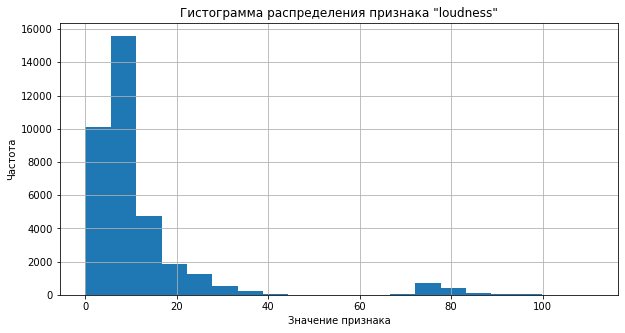

In [69]:
ax =(df_train['loudness']
     .plot(kind='hist', bins=20,figsize=(10,5),
           title='Гистограмма распределения признака "loudness"',
           grid=True)
)
ax.set_xlabel('Значение признака')
ax.set_ylabel('Частота')
plt.show()

Большая часть песен находится в диапозоне до 20дБ. Признак не ограничен значением "сверху", поэтому проверим выбросы/аномалии с помощью boxplot

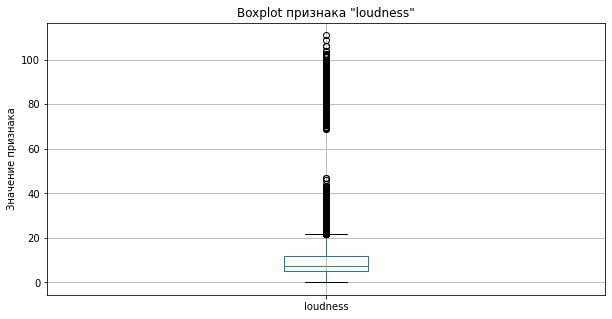

In [70]:
ax =(df_train['loudness']
     .plot(kind='box',figsize=(10,5),
           title='Boxplot признака "loudness"',
           grid=True)
)
ax.set_ylabel('Значение признака')
plt.show()

По boxplot выбросами считаются все значения свыше 20дБ. Однако стоит выделить часть, которая идет после 60дБ. Рассмотрим гистограммы для треков с показателем до 60дБ и свыше 60дБ:

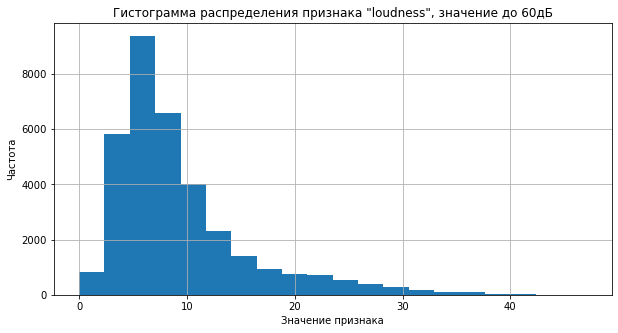

In [71]:
# распределение песен с треками до 60дБ
ax =(df_train.query('loudness<=60')['loudness']
     .plot(kind='hist', bins=20,figsize=(10,5),
           title='Гистограмма распределения признака "loudness", значение до 60дБ',
           grid=True)
)
ax.set_xlabel('Значение признака')
ax.set_ylabel('Частота')
plt.show()

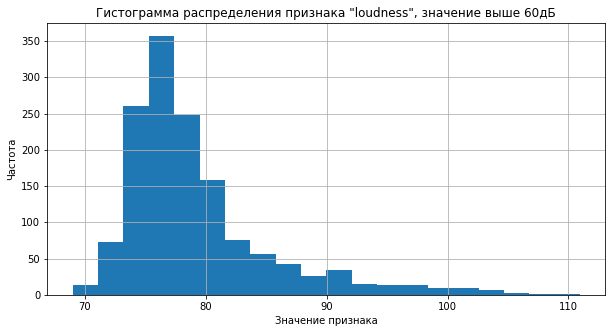

In [72]:
# распределение песен с треками свыше 60дБ
ax =(df_train.query('loudness>60')['loudness']
     .plot(kind='hist', bins=20,figsize=(10,5),
           title='Гистограмма распределения признака "loudness", значение выше 60дБ',
           grid=True)
)
ax.set_xlabel('Значение признака')
ax.set_ylabel('Частота')
plt.show()

Гистограммы получились похожими. Возможно, у части треков этот параметр почему-то оказался выше, чем у основной массы треков, хотя распределение по жанрам в обеих группах одинаковое (или близкое, таблица ниже). Если это так, то можно ожидать, что группа треков с параметром выше 60дБ будет "путать" алгоритм. Рассмотрим распределение жанров в следующих группах:
- до 60дБ
- выше 60дБ
- без разделения

In [73]:
pd.concat([df_train.loc[df_train['loudness']<=60,'music_genre'].value_counts(normalize=True).rename('до 60дБ'),
           df_train.loc[df_train['loudness']>60,'music_genre'].value_counts(normalize=True).rename('выше 60дБ'),
           df_train['music_genre'].value_counts(normalize=True).rename('без разделения')]
          ,axis=1)
           

,до 60дБ,выше 60дБ,без разделения
Anime,0.112094,0.084099,0.110987
Electronic,0.109387,0.091873,0.108694
Jazz,0.107117,0.099647,0.106821
Country,0.105574,0.100353,0.105368
Blues,0.105021,0.118021,0.105535
Classical,0.104352,0.092580,0.103886
Rock,0.095154,0.106007,0.095583
Alternative,0.093553,0.098233,0.093738
Hip-Hop,0.084413,0.108834,0.085379
Rap,0.083336,0.100353,0.084009


Выше видно, что в группе выше 60дБ распределение жанров немного отличается от распределения жанров в группе до 60дБ, но в целом они все равно похожи.

Ниже пример того, как эти данные могут путать алгоритм:

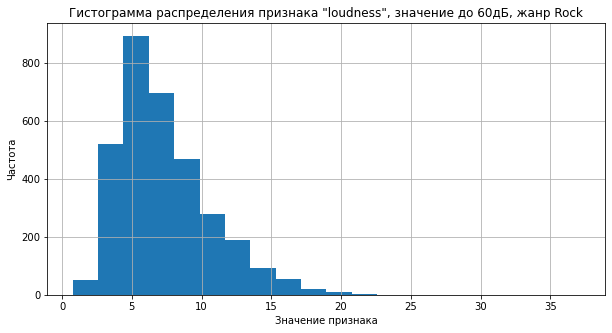

In [74]:
# распределение песен с треками до 60дБ, жанр Rock
ax =(df_train.query('loudness<=60 and music_genre=="Rock"')['loudness']
     .plot(kind='hist', bins=20,figsize=(10,5),
           title='Гистограмма распределения признака "loudness", значение до 60дБ, жанр Rock',
           grid=True)
)
ax.set_xlabel('Значение признака')
ax.set_ylabel('Частота')
plt.show()

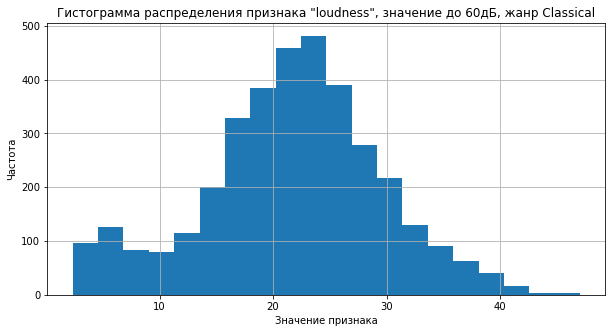

In [75]:
# распределение песен с треками до 60дБ, жанр Classical
ax =(df_train.query('loudness<=60 and music_genre=="Classical"')['loudness']
     .plot(kind='hist', bins=20,figsize=(10,5),
           title='Гистограмма распределения признака "loudness", значение до 60дБ, жанр Classical',
           grid=True)
)
ax.set_xlabel('Значение признака')
ax.set_ylabel('Частота')
plt.show()

Выше видно, что при значении параметра 30дБ скорее речь будет идти о классической музыке, но не о роке. 

Теперь рассмотрим гистограммы для параметра >=60:

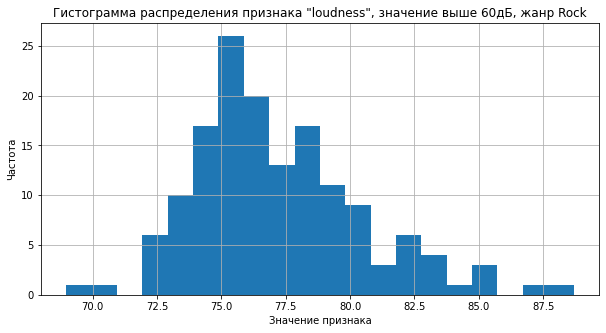

In [76]:
# распределение песен с треками выше 60дБ, жанр Rock
ax =(df_train.query('loudness>60 and music_genre=="Rock"')['loudness']
     .plot(kind='hist', bins=20,figsize=(10,5),
           title='Гистограмма распределения признака "loudness", значение выше 60дБ, жанр Rock',
           grid=True)
)
ax.set_xlabel('Значение признака')
ax.set_ylabel('Частота')
plt.show()

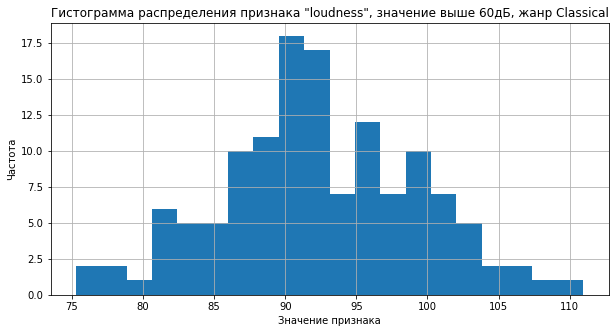

In [77]:
# распределение песен с треками выше 60дБ, жанр Classical
ax =(df_train.query('loudness>60 and music_genre=="Classical"')['loudness']
     .plot(kind='hist', bins=20,figsize=(10,5),
           title='Гистограмма распределения признака "loudness", значение выше 60дБ, жанр Classical',
           grid=True)
)
ax.set_xlabel('Значение признака')
ax.set_ylabel('Частота')
plt.show()

Как видно выше, жанр Rock также характерен для треков с `loudness` в районе 77, его можно отличить по этому параметру от классической музыки.

Скорее всего, это либо ошибка, либо какие-то особенности музыкальных записей. Скорректируем треки со значением признака свыше 60дБ, вычтя минимальное для этой группы значение.

In [78]:
df_train['loudness_upd'] = df_train['loudness']
idx = (df_train['loudness'] >= 60)
min_value_over_60 = df_train.loc[idx, 'loudness'].min()
df_train.loc[idx, 'loudness_upd'] = df_train.loc[idx, 'loudness'] - min_value_over_60

Гистограмма после всех корректировок.

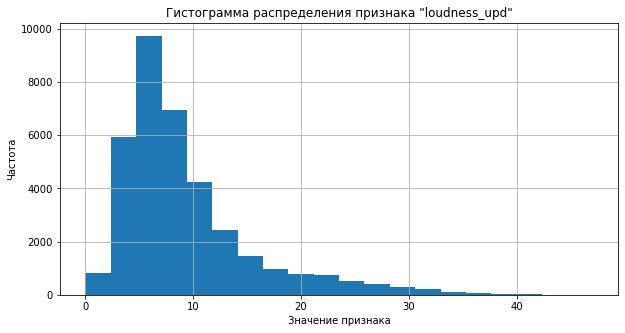

In [79]:
ax =(df_train['loudness_upd']
     .plot(kind='hist', bins=20,figsize=(10,5),
           title='Гистограмма распределения признака "loudness_upd"',
           grid=True)
)
ax.set_xlabel('Значение признака')
ax.set_ylabel('Частота')
plt.show()

Аналогичные преобразования проделываются с тестовой выборкой

In [80]:
df_test['loudness_upd'] = df_test['loudness']
idx = (df_test['loudness'] >= 60)
# min_value_over_60 = df_train.loc[idx, 'loudness'].min() берем с train
df_test.loc[idx, 'loudness_upd'] = df_test.loc[idx, 'loudness'] - min_value_over_60

### Признак `key`:

Построим barplot распределения признака.

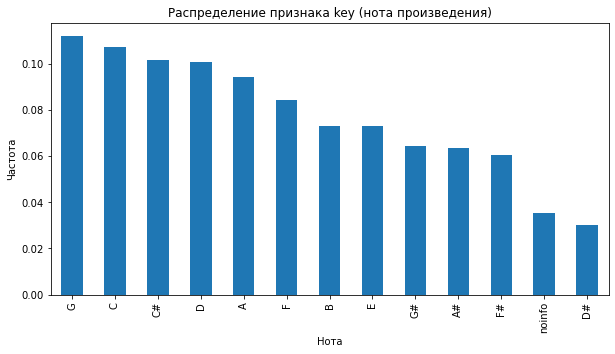

In [81]:
(
df_train['key']
    .value_counts(normalize=True)
    .plot(kind='bar', figsize=(10,5),
          title='Распределение признака key (нота произведения)',
          xlabel='Нота', ylabel='Частота')
)
plt.show()

Здесь стоит отметить следующее:
- преобладание треков с базовым ключом без #;
- наличие категории "noinfo", которая превосходит категорию "D#";

Сделаем модификацию этого признака: аккорды идут слева направо от А до D. Введем порядок, занумировав значения от -1 до 11, где -1 - это пропуски.

In [82]:
for_rep = (df_train.query('key != "noinfo"')['key']
         .drop_duplicates()
         .sort_values()
         .reset_index(drop=True)
         .reset_index()
         .set_index('key')
        ).to_dict()
    
for_rep

{'index': {'A': 0,
  'A#': 1,
  'B': 2,
  'C': 3,
  'C#': 4,
  'D': 5,
  'D#': 6,
  'E': 7,
  'F': 8,
  'F#': 9,
  'G': 10,
  'G#': 11}}

In [83]:
# train
df_train['key_upd'] = df_train['key'].map(for_rep['index']).fillna(-1)
# test
df_test['key_upd'] = df_test['key'].map(for_rep['index']).fillna(-1)

### Признак `mode`:

Построим barplot распределения признака.

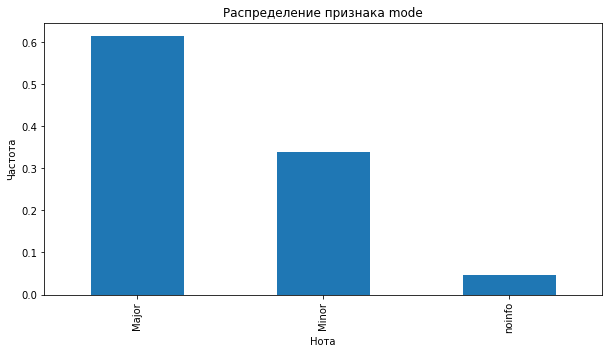

In [84]:
(
df_train['mode']
    .value_counts(normalize=True)
    .plot(kind='bar', figsize=(10,5),
          title='Распределение признака mode',
          xlabel='Нота', ylabel='Частота')
)
plt.show()

Стоит выделить следюущее:
- преобладает мажорная тональность (примерно в 2 раза);
- есть категория "noinfo", в которую попали пропуски в столбце;

### Признак `speechiness`:

Построим гистограмму распределения признака.

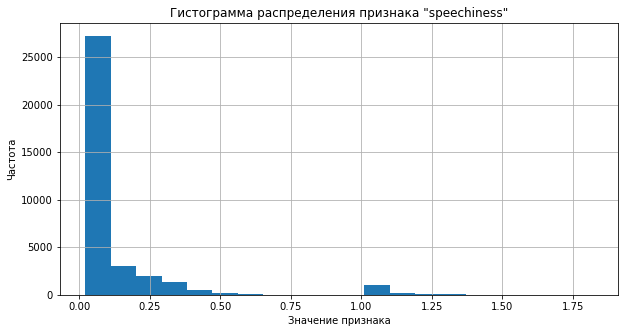

In [85]:
ax =(df_train['speechiness']
     .plot(kind='hist', bins=20,figsize=(10,5),
           title='Гистограмма распределения признака "speechiness"',
           grid=True)
)
ax.set_xlabel('Значение признака')
ax.set_ylabel('Частота')
plt.show()

На гистограмме видны значения > 1, чего, судя по описанию, быть не должно. Картина распределения признака чем-то похожа на гистограмму признака `loudness`. Рассмотрим распределение признака для значения <=1:

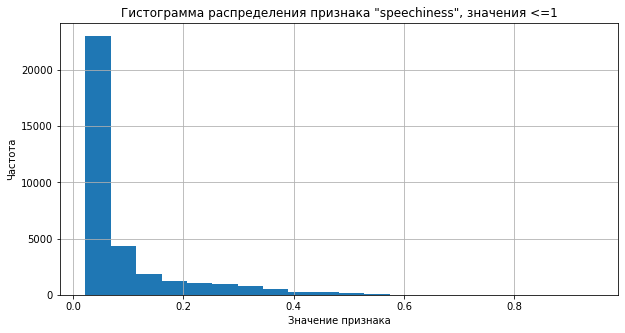

In [86]:
ax =(df_train.query('speechiness <= 1')['speechiness']
     .plot(kind='hist', bins=20,figsize=(10,5),
           title='Гистограмма распределения признака "speechiness", значения <=1',
           grid=True)
)
ax.set_xlabel('Значение признака')
ax.set_ylabel('Частота')
plt.show()

Рассмотрим распределение признака для значения >1:

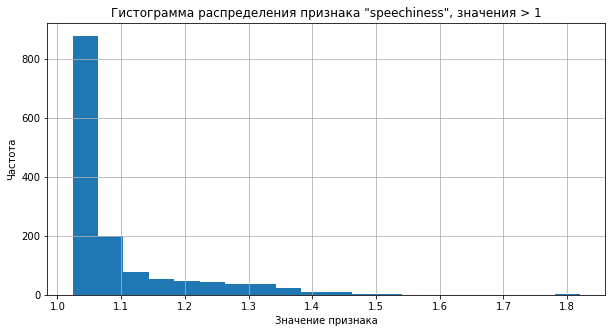

In [87]:
ax =(df_train.query('speechiness > 1')['speechiness']
     .plot(kind='hist', bins=20,figsize=(10,5),
           title='Гистограмма распределения признака "speechiness", значения > 1',
           grid=True)
)
ax.set_xlabel('Значение признака')
ax.set_ylabel('Частота')
plt.show()

Ситуация схожа с тем, что было с `loudness`, только параметр отличается.
Проделаем аналогичные процедуры по корректировке:

In [88]:
df_train['speechiness_upd'] = df_train['speechiness']
idx = (df_train['speechiness'] > 1)
df_train.loc[idx,'speechiness_upd'] = (df_train.loc[idx, 'speechiness'] - 1.)

Гистограмма после корректировки признака:

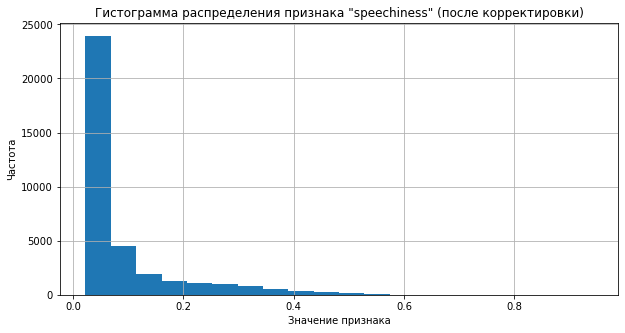

In [89]:
ax =(df_train['speechiness_upd']
     .plot(kind='hist', bins=20,figsize=(10,5),
           title='Гистограмма распределения признака "speechiness" (после корректировки)',
           grid=True)
)
ax.set_xlabel('Значение признака')
ax.set_ylabel('Частота')
plt.show()

Аналогичные преобразования выполняются для теста

In [90]:
df_test['speechiness_upd'] = df_test['speechiness']
idx = (df_test['speechiness'] > 1)
df_test.loc[idx,'speechiness_upd'] = (df_test.loc[idx, 'speechiness'] - 1.)

### Признак `tempo`:

Построим гистограмму распределения признака.

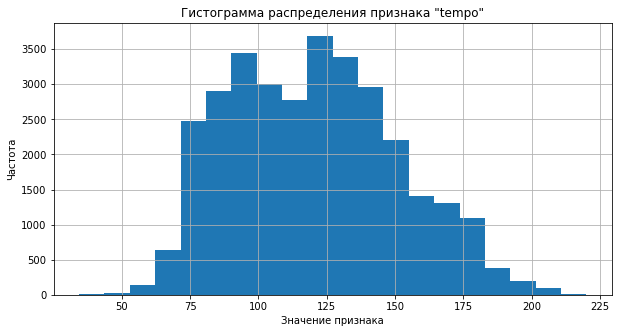

In [91]:
ax =(df_train['tempo']
     .plot(kind='hist', bins=20,figsize=(10,5),
           title='Гистограмма распределения признака "tempo"',
           grid=True)
)
ax.set_xlabel('Значение признака')
ax.set_ylabel('Частота')
plt.show()

На графике видны два пика - один в районе 95, другой - в районе 125. Возможно, какие-то жанры выделятся. Раздели выборку на две части по среднему зачению, равному 120.

In [92]:
share = pd.concat([df_train.query('tempo<=120')['music_genre'].value_counts(normalize=True).rename('tempo_lower_120_share'),
                   df_train.query('tempo>120')['music_genre'].value_counts(normalize=True).rename('tempo_over_120_share')],
                   axis=1)

In [93]:
mean_tempo = pd.concat([df_train.query('tempo<=120')[['music_genre','tempo']].groupby('music_genre').mean(),
                        df_train.query('tempo>120')[['music_genre','tempo']].groupby('music_genre').mean()],
                        axis=1)
mean_tempo.columns = ['mean_tempo_lower_120','mean_tempo_over_120']

In [94]:
pd.concat([share,mean_tempo],axis=1)

,tempo_lower_120_share,tempo_over_120_share,mean_tempo_lower_120,mean_tempo_over_120
Classical,0.144547,0.062205,87.037911,143.566251
Jazz,0.142279,0.070650,94.384807,146.336639
Blues,0.106740,0.103674,97.438108,146.941100
Country,0.093873,0.116720,97.062827,147.023093
Anime,0.092218,0.129325,94.522054,149.932519
Rock,0.090870,0.103170,98.007774,145.142180
Alternative,0.087990,0.099137,97.366070,147.093917
Electronic,0.081066,0.135627,99.790734,142.700660
Hip-Hop,0.080515,0.090880,94.330574,144.899829
Rap,0.079902,0.088612,95.176239,144.137250


Как видно из выкладок выше, есть жанры, которые преобладают в группе `tempo_lower_120`. Например, классическая музыка, джаз. Средний темп у первого жанра самый низкий в группе - 89 bpm, а самый редкий жанр в группе - электронная музыка - имеет самый высокий средний тем в группе. 

И наоборот, в группе `tempo_over_120` у классической музыки самая низкая доля, а у электронной - самая высокая. Что интересно, средний темп у классической музыки находится близко к среднему всей группы.

Этот признак точно будет полезен при определении жанра. Что-то корректировать не требуется.

### Признак `valence`:

Построим гистограмму распределения признака.

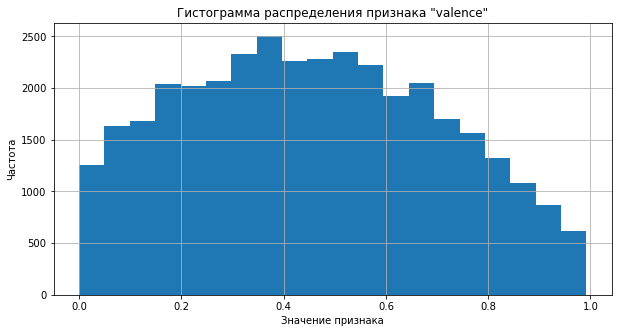

In [95]:
ax =(df_train['valence']
     .plot(kind='hist', bins=20,figsize=(10,5),
           title='Гистограмма распределения признака "valence"',
           grid=True)
)
ax.set_xlabel('Значение признака')
ax.set_ylabel('Частота')
plt.show()

Стоит отметить дисбаланс треков в сторону более грустных. Потенциально признак можно использовать при заполнении признаков `mode` и `tempo`.

### Корреляции:

Коэффициент корреляции Пирсона:

In [96]:
df_train.drop(['instance_id','speechiness','loudness'],axis=1).corr()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,tempo,valence,loudness_upd,key_upd,speechiness_upd
popularity,1.000000,-0.269530,0.344767,-0.069012,0.196640,-0.346620,-0.045720,0.036181,0.122092,-0.295076,-0.001925,0.203364
acousticness,-0.269530,1.000000,-0.343802,0.011434,-0.796240,0.380627,-0.110861,-0.243147,-0.271534,0.732308,0.004560,-0.161642
danceability,0.344767,-0.343802,1.000000,-0.149722,0.269921,-0.287482,-0.050516,-0.014659,0.439062,-0.390967,-0.017652,0.267883
duration_ms,-0.069012,0.011434,-0.149722,1.000000,-0.025567,0.122090,0.030405,-0.026252,-0.155917,0.068635,-0.004262,-0.116197
energy,0.196640,-0.796240,0.269921,-0.025567,1.000000,-0.387406,0.192885,0.276669,0.393593,-0.840292,-0.002971,0.166729
instrumentalness,-0.346620,0.380627,-0.287482,0.122090,-0.387406,1.000000,-0.096495,-0.132042,-0.272082,0.524473,-0.005111,-0.183808
liveness,-0.045720,-0.110861,-0.050516,0.030405,0.192885,-0.096495,1.000000,0.047608,0.053358,-0.130979,0.001023,0.118404
tempo,0.036181,-0.243147,-0.014659,-0.026252,0.276669,-0.132042,0.047608,1.000000,0.112629,-0.253063,0.000357,0.078512
valence,0.122092,-0.271534,0.439062,-0.155917,0.393593,-0.272082,0.053358,0.112629,1.000000,-0.339614,-0.001262,0.054191
loudness_upd,-0.295076,0.732308,-0.390967,0.068635,-0.840292,0.524473,-0.130979,-0.253063,-0.339614,1.000000,0.002634,-0.165627


Значения коэффициента корреляции между:
-`energy` и `acousticness` = 0.796240, 
-`loudness_upd` и `energy` = 0.840292
-`loudness_upd` и `acousticness` = 0.732308

Для линейных моделей это может быть проблемой, если использовать эти признаки вместе.

Расчет корреляции с помощью библиотеки `phik`:

In [97]:
df_train.drop(['instance_id','track_name','obtained_date','speechiness','loudness'],axis=1).phik_matrix()

interval columns not set, guessing: ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'tempo', 'valence', 'loudness_upd', 'key_upd', 'speechiness_upd']


,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,mode,tempo,valence,music_genre,loudness_upd,key_upd,speechiness_upd
popularity,1.000000,0.367598,0.368448,0.310381,0.384668,0.368097,0.071851,0.101443,0.020679,0.132318,0.208817,0.798558,0.393551,0.078346,0.258504
acousticness,0.367598,1.000000,0.488654,0.289092,0.771212,0.474561,0.104843,0.199192,0.029255,0.349387,0.427610,0.667701,0.718045,0.125040,0.227521
danceability,0.368448,0.488654,1.000000,0.269846,0.540815,0.356735,0.101827,0.128240,0.091530,0.401159,0.563043,0.640276,0.510070,0.127679,0.338505
duration_ms,0.310381,0.289092,0.269846,1.000000,0.310370,0.357164,0.047269,0.134688,0.048689,0.135191,0.244542,0.410077,0.357961,0.060672,0.171100
energy,0.384668,0.771212,0.540815,0.310370,1.000000,0.469106,0.096038,0.279899,0.035724,0.400737,0.507685,0.682676,0.846275,0.112720,0.251110
instrumentalness,0.368097,0.474561,0.356735,0.357164,0.469106,1.000000,0.041161,0.155812,0.089056,0.232144,0.373251,0.572958,0.523428,0.040141,0.201602
key,0.071851,0.104843,0.101827,0.047269,0.096038,0.041161,1.000000,0.046027,0.298588,0.038527,0.047420,0.164288,0.090981,1.000000,0.110725
liveness,0.101443,0.199192,0.128240,0.134688,0.279899,0.155812,0.046027,1.000000,0.019539,0.095116,0.148030,0.216075,0.229246,0.046801,0.145318
mode,0.020679,0.029255,0.091530,0.048689,0.035724,0.089056,0.298588,0.019539,1.000000,0.020740,0.037277,0.251265,0.008672,0.279516,0.087059
tempo,0.132318,0.349387,0.401159,0.135191,0.400737,0.232144,0.038527,0.095116,0.020740,1.000000,0.280233,0.346493,0.370014,0.042454,0.170462


Библиотеки phik подтверждает результаты выше.


### Заполнение пропусков:

Попробуем заполнить пропуски в этом признаке исходя из признака `valence`, т.к. признак имеет распределение, которое более-менее покрывает все треки.

In [98]:
# train
# создание категории
df_train['group_dance']=((df_train['valence']*100//10)*10).astype(int).astype(str)
# таблица для заполнения данных
for_fill_dance = df_train[['danceability','group_dance']].groupby('group_dance').agg(func=['mean','median','count'])
for_fill_dance.columns = ['mean','median','count']
# смотрим результат + количество объектов и выбираем нужный столбец (среднее или медиану)
display(for_fill_dance)
# заполняем данные в train
idx = df_train[df_train['danceability'].isna()].index
df_train.loc[idx,['danceability']] = df_train.loc[idx,'group_dance'].map(for_fill_dance.to_dict()['median'])

# то же для теста
# создание категории
df_test['group_dance']=((df_test['valence']*100//10)*10).astype(int).astype(str)
# заполняем данные в test
idx = df_test[df_test['danceability'].isna()].index
df_test.loc[idx,['danceability']] = df_test.loc[idx,'group_dance'].map(for_fill_dance.to_dict()['median'])

,mean,median,count
group_dance,,,
0,0.333559,0.289,2782
10,0.470621,0.458,3555
20,0.519772,0.509,3916
30,0.552314,0.545,4628
40,0.570856,0.568,4360
50,0.592647,0.592,4313
60,0.614239,0.615,3788
70,0.627231,0.629,3050
80,0.654959,0.660,2292


Аналогичным способом заполняем `tempo` по признаку `energy`.

In [99]:
# train
df_train['group_tempo']=((df_train['energy']*100//10)*10).astype(int).astype(str)
for_fill_tempo = df_train[['tempo','group_tempo']].groupby('group_tempo').agg(func=['mean','median','count'])
for_fill_tempo.columns = ['mean','median','count']
display(for_fill_tempo)

idx = df_train[df_train['tempo'].isna()].index
df_train.loc[idx,['tempo']] = df_train.loc[idx,'group_tempo'].map(for_fill_tempo.to_dict()['median'])

# то же для теста
df_test['group_tempo']=((df_test['energy']*100//10)*10).astype(int).astype(str)
idx = df_test[df_test['tempo'].isna()].index
df_test.loc[idx,['tempo']] = df_test.loc[idx,'group_tempo'].map(for_fill_tempo.to_dict()['median'])



,mean,median,count
group_tempo,,,
0,98.747858,91.1000,2189
10,106.346764,99.9095,1534
20,111.831261,108.9750,1675
30,116.256080,114.6330,2116
40,117.669069,117.2960,3073
50,118.653088,118.1215,3888
60,121.554527,120.0465,4402
70,122.830864,121.4180,4467
80,126.124651,125.0100,4678


Аналогичным способом заполняем `popularity` по признаку `danceability`.

In [100]:
# train
df_train['group_pop']=((df_train['danceability']*100//10)*10).astype(int).astype(str)
for_fill_pop = df_train[['popularity','group_pop']].groupby('group_pop').agg(func=['mean','median','count'])
for_fill_pop.columns = ['mean','median','count']
display(for_fill_pop)

idx = df_train[df_train['popularity'].isna()].index
df_train.loc[idx,['popularity']] = df_train.loc[idx,'group_pop'].map(for_fill_pop.to_dict()['median'])

# # то же для теста
df_test['group_pop']=((df_test['danceability']*100//10)*10).astype(int).astype(str)
idx = df_test[df_test['popularity'].isna()].index
df_test.loc[idx,['popularity']] = df_test.loc[idx,'group_pop'].map(for_fill_pop.to_dict()['median'])

,mean,median,count
group_pop,,,
0,31.090395,33.0,177
10,30.971831,32.0,923
20,33.613422,34.0,1803
30,37.051613,37.0,3100
40,40.462664,40.0,5263
50,42.854839,43.0,7564
60,44.975577,45.0,6674
70,48.587610,50.0,4326
80,52.655022,53.0,2061


Аналогичным способом заполняем `duration_ms` по признаку `danceability`.

In [101]:
# train
for_fill_duration = df_train[['duration_ms','group_dance']].groupby('group_dance').agg(func=['mean','median','count'])
for_fill_duration.columns = ['mean','median','count']
display(for_fill_duration)

idx = df_train[df_train['duration_ms'].isna()].index
df_train.loc[idx,['duration_ms']] = df_train.loc[idx,'group_dance'].map(for_fill_duration.to_dict()['median'])

# то же для теста
idx = df_test[df_test['duration_ms'].isna()].index
df_test.loc[idx,['duration_ms']] = df_test.loc[idx,'group_dance'].map(for_fill_duration.to_dict()['median'])

,mean,median,count
group_dance,,,
0,268893.984164,251107.0,2589
10,254954.333029,241506.0,3291
20,248368.184232,235893.0,3691
30,240733.214827,229667.0,4357
40,235435.507125,224820.0,4070
50,233869.062683,222640.0,4100
60,231666.114438,222506.5,3574
70,228260.336498,218380.0,2844
80,223113.527765,215092.0,2143


<b>Выводы по этапу:</b>
- На данном этапе были заполнены пропуски у части признаков;
- Признаки были проверены на адекватность.
- Составлено представление о распределении признаков, дополнительно изучено их описание.
- Созданы новые признаки `loudness_upd` и `speechiness_upd`, в которых данные были скорректированы.
- Были удалены выбросы, которые определялись по признаку `duration_ms`: удалены объекты со значением > 600 000 м.с.
- Изучены корреляции между признаками. Здесь стоит выделить достаточно высокое значение корреляции между признаками `energy` и `acousticness`.
- Вместо категориального признака `key` создан `key_upd`.

Список удаленных строк после корректировок:

In [102]:
print(f'Итого удалено строк исходного массива после предобработки и EDA: {sum(delete_rows_reasons.values())/df_train_before_count[0]:.2%}')

Итого удалено строк исходного массива после предобработки и EDA: 10.57%


# Этап 4. Подготовка данных. Разбиение, кодирование и масштабирование, создание пайплайна

### Разбиение признаков на обучающие и целевой.

In [103]:
df_train.columns

Index(['instance_id', 'track_name', 'popularity', 'acousticness',
       'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'obtained_date',
       'valence', 'music_genre', 'loudness_upd', 'key_upd', 'speechiness_upd',
       'group_dance', 'group_tempo', 'group_pop'],
      dtype='object')

Разбиение:

In [104]:
X = df_train.drop(['instance_id','obtained_date','speechiness','loudness', 'key', 
                   'track_name','music_genre','group_pop','group_tempo','group_dance'
                  ], axis=1)
y = df_train['music_genre']


Проврерка разбиения:

In [105]:
display(X.head())
y.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,mode,tempo,valence,loudness_upd,key_upd,speechiness_upd
0,33.0,0.000718,0.501,241506.0,0.935,0.020100,0.0831,Minor,144.922,0.1880,5.566,11.0,0.1570
1,55.0,0.064700,0.282,288333.0,0.738,0.014200,0.2900,Major,126.914,0.2110,5.566,3.0,0.0324
2,39.0,0.931000,0.364,115240.0,0.349,0.940000,0.1100,noinfo,65.427,0.0891,13.279,-1.0,0.0321
3,56.0,0.012300,0.332,234638.0,0.847,0.000027,0.2970,Minor,67.230,0.3920,4.513,2.0,0.0910
4,52.0,0.580000,0.716,221640.0,0.614,0.000014,0.1600,Major,88.006,0.6800,7.099,10.0,0.0360


0     Electronic
1    Alternative
2      Classical
3     Electronic
4        Country
Name: music_genre, dtype: object

Выделяются числовые и категориальные признаки:

In [106]:
num_cols = X.select_dtypes(include='number').columns
obj_cols = X.select_dtypes(include='object').columns

### Создание Pipeline.

Трансформеры для обработки признаков:

In [107]:
# трансформер для масштабирования числовых признаков
numeric_transformer = StandardScaler()
# трансформер для преобразования категориальных признаков
cat_transformer = OneHotEncoder(drop='first')
# сборка трансформера для преобразования признаков
preproc = ColumnTransformer(transformers=[('num', numeric_transformer, num_cols), 
                                          ('cat', cat_transformer, obj_cols)],
                            remainder='passthrough')

Пайплайны с различными моделями, которые будут подаваться в GridSearchCV.

In [108]:
LogReg = Pipeline(steps=[('prepocessor', preproc), 
                         ('estimator', LogisticRegression())])
DesTree = Pipeline(steps=[('prepocessor', preproc), 
                          ('estimator', DecisionTreeClassifier(random_state=12345))])
RanForest = Pipeline(steps=[('prepocessor', preproc), 
                            ('estimator', RandomForestClassifier(random_state=12345, n_jobs=-1))])
CBC = Pipeline(steps=[('prepocessor', preproc), 
                      ('estimator', CatBoostClassifier(
                                                       early_stopping_rounds=200,
                                                       task_type='GPU',
                                                       random_state=12345,
                                                       # cat_features=obj_cols.to_list(),
                                                       verbose=False))])

In [109]:
CBC.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'prepocessor', 'estimator', 'prepocessor__n_jobs', 'prepocessor__remainder', 'prepocessor__sparse_threshold', 'prepocessor__transformer_weights', 'prepocessor__transformers', 'prepocessor__verbose', 'prepocessor__num', 'prepocessor__cat', 'prepocessor__num__copy', 'prepocessor__num__with_mean', 'prepocessor__num__with_std', 'prepocessor__cat__categories', 'prepocessor__cat__drop', 'prepocessor__cat__dtype', 'prepocessor__cat__handle_unknown', 'prepocessor__cat__sparse', 'estimator__verbose', 'estimator__task_type', 'estimator__random_state', 'estimator__early_stopping_rounds'])

# Этап 5. Кросс-валидация, выбор модели и предсказание теста.

Для каждой модели делается свой пайплайн, итоговый результат записывается в result

In [110]:
# словарь, куда будем сохранять результаты
results = {}
# классы моделей и сетка гиперпараметров для подбора для каждого класса:
estimators = {
              'Логистическая регрессия': {'estimator': LogReg, 
                                      'param_grid': {'estimator__penalty': ['l2'],
                                                     'estimator__solver':['newton-cg', 'sag' ,'saga','lbfgs'],
                                                     'estimator__multi_class': ['ovr', 'multinomial'],
                                                    }
                                    },
              'Дерево решений': {'estimator': DesTree,
                                 'param_grid': {'estimator__max_depth': range(10, 30, 2),
                                                'estimator__splitter':['best', 'random']
                                               }
                            }, 
              'Случайный лес': {'estimator': RanForest,
                                 'param_grid': {'estimator__max_depth': range(10, 28, 3),
                                                'estimator__n_estimators': range(70, 310, 50)
                                               }
                                },
              'CatBoost': {'estimator': CBC,
                                      'param_grid': {'estimator__learning_rate':[0.03, 0.04, 0.05, 0.06],#, 0.2, 0.4],
                                                     'estimator__n_estimators': [1000,1100,1200,1300,1400],
                                                     'estimator__max_depth': [3,5,6,7],
                                                     'estimator__loss_function':['MultiClass']   
                                                       }
                           } 
          }
# Обучение и запись результата:
for name, estimator in estimators.items():
    
    search = GridSearchCV(estimator=estimator['estimator'], 
                          param_grid=estimator['param_grid'],
                          cv=3,
                          scoring='f1_micro')
    
    results[name]=search.fit(X, y)
    print(f'Лучший результат модели {name} = {search.best_score_}')

Лучший результат модели Логистическая регрессия = 0.5225608708284134
Лучший результат модели Дерево решений = 0.5077438827654309
Лучший результат модели Случайный лес = 0.5831142315601482
Лучший результат модели CatBoost = 0.6024042049833932


Оценка

In [111]:
for model_name, model_res in results.items():
    print(f"\nТоп 3 лучших результата результаты модели {model_name} :")
    display(pd.DataFrame(model_res.cv_results_)[['rank_test_score', 
                                                'mean_test_score',
                                                'std_test_score']]
            .sort_values(by='rank_test_score')[:3]
           )
        


Топ 3 лучших результата результаты модели Логистическая регрессия :


,rank_test_score,mean_test_score,std_test_score
5,1,0.522561,0.001760
7,1,0.522561,0.001760
4,3,0.522533,0.001731



Топ 3 лучших результата результаты модели Дерево решений :


,rank_test_score,mean_test_score,std_test_score
0,1,0.507744,0.001436
2,2,0.503830,0.006365
3,3,0.487783,0.000632



Топ 3 лучших результата результаты модели Случайный лес :


,rank_test_score,mean_test_score,std_test_score
13,1,0.583114,0.004204
14,2,0.582723,0.003959
12,3,0.582527,0.003831



Топ 3 лучших результата результаты модели CatBoost :


,rank_test_score,mean_test_score,std_test_score
33,1,0.602404,0.001281
32,2,0.602208,0.001743
29,3,0.602208,0.002940


In [112]:
# # запись в файл
# for name in results.keys():
#     res = pd.DataFrame(results[name].cv_results_).to_csv(f'Лучшие параметры для {name}.csv')

Выбор модели. Выполянется исходя из метрик `mean_test_score` и `std_test_score`. Значение метрики `std_test_score` должно быть до 0.0025. Выбирается модель с лучшим `mean_test_score`.

In [117]:
# Логистическая регрессия
# Дерево решений
# Случайный лес
# CatBoost

best_model_name = 'CatBoost'

# CatBoost (для обучения)
CBC = Pipeline(steps=[('prepocessor', preproc), 
                      ('estimator', CatBoostClassifier(
                                                       early_stopping_rounds=200,
                                                       task_type='GPU',
                                                       random_state=12345,
                                                       # cat_features=obj_cols.to_list(),
                                                       verbose=False))])


# 1, 2, 3
chosen_model = 1
model_position = np.where(results[best_model_name].cv_results_['rank_test_score']==chosen_model)[0][0]

# Инициализация выбранной модели
estimator = CBC.set_params(**results[best_model_name].cv_results_['params'][model_position])
# проверка 
display(estimator['estimator'].get_params())
# обучение выбранной модели
estimator.fit(X,y)
# название признаков в модели
features = (list(estimator.named_steps['prepocessor'].transformers_[0][2]) 
            + list(estimator.named_steps['prepocessor'].transformers_[1][1].get_feature_names(obj_cols)))
estimator['estimator'].set_feature_names(features)

{'verbose': False,
 'task_type': 'GPU',
 'random_state': 12345,
 'early_stopping_rounds': 200,
 'learning_rate': 0.04,
 'loss_function': 'MultiClass',
 'max_depth': 6,
 'n_estimators': 1300}

Предсказание для `Kaggle`

In [118]:
# обработка тестовых признаков
X_test = df_test.drop(['instance_id','obtained_date','speechiness','loudness',
                   'track_name','group_pop','group_tempo','group_dance','key'
                  ], axis=1)
# предсказание 
predict = estimator.predict(X_test)

Запись в файл:

In [119]:
(pd.concat([df_test['instance_id'], pd.Series(predict[:,0], name='music_genre')],axis=1)
 .to_csv('submission.csv', index=False))

# Этап 6. Влияние признаков на предсказание.

Воспользуемся атрибутом feature_importance_ `Catboost`

In [120]:
estimator['estimator'].get_feature_importance(prettified=True)

,Feature Id,Importances
0,popularity,30.792015
1,speechiness_upd,11.283892
2,danceability,11.086504
3,instrumentalness,8.700401
4,acousticness,7.058931
5,loudness_upd,6.419705
6,valence,5.567007
7,duration_ms,4.968689
8,energy,4.854479
9,tempo,3.439355


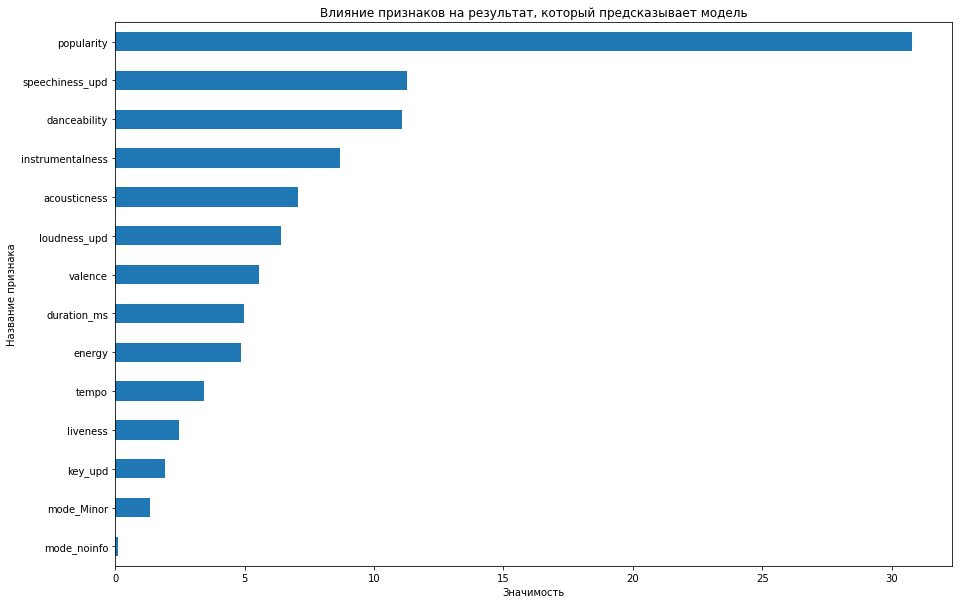

In [121]:
ax=(estimator['estimator']
   .get_feature_importance(prettified=True)
   .rename(columns={'Importances':'Значимость',
                  'Feature Id': 'Название признака'}
        )
   .set_index('Название признака')
   .sort_values(by='Значимость')
   .plot(kind='barh', 
         figsize=(15,10),
         legend=False)
  )
ax.set_xlabel('Значимость')
ax.set_title('Влияние признаков на результат, который предсказывает модель')

plt.show()

Как видно из столбчатой диаграммы:
- самый значимый признак при определении жанра оказался `popularity` или популярность трека. Причем отрыв от следующего значимого признака в 3 раза.
- следующими примерно одинаковыми по значимости оказались `speechiness_upd` (скорректированная версия исходного признака `speechiness`) и `dancebility`. Эти признаки отвечают за речь в музыкальном треке и танцевальность трека соответственно.
- слабо влияющие на результата признаки: `tempo` (темп музыки bpm), `mode_Minor` (признак того, что трек минорный), `liveness` - признак исполнения в живую, `key_upd` - обработанная версия поля `key`. В этой подборке немного странно выглядит поле `tempo`, которое в теории должно было бы неплохо помочь в определении жанра, но, возможно, проблема в обработке или недостаточном понимании данных.
- вообще не оказало влияние на результат поле`mode_noinfo`.

# Этап 7. Итоги. Общий вывод.

<h3>Основные итоги:</h3>

<ins>Цель проекта:</ins><br>
Разработать алгоритм классификации музыки по 10 жанрам на основании 16 входных параметров. 

<ins>Метрика проекта:</ins><br>
Для контроля качества обучения и результатов использовалась метрика `F1 micro`.

<ins>Данные для обучения:</ins><br>
Предоставлены музыкальным стриминговым сервисом "МиФаСоль". В обучающем датасете 40 000 объектов, в тестовом 10 000 объектов. К данным предоставлено описание.

<ins>Рассматриваемы модели:</ins><br>
Рассматривались модели из следующих семейств:
- Логистическая регрессия (LogisticRegression);
- Дерево решений (DecisionTreeClassifier);
- Случайный лес (RandomForestClassifier);
- Градиентный бустинг (CatBoostClassifier);

Параметры подбирались методом GridSearchCV с параметрос cv=3 из набора заданных параметров.

<ins>Лучшая модель:</ins><br>
Лучшая модель оказалась CatBoostClassifier с параметрами:
- `learning_rate` = 0.04;
- `max_depth` = 6;
- `n_estimators` = 1300
- `early_stopping_rounds`=200
- `random_state` = 12345
- Остальные параметры брались по умолчанию.

<ins>Результат модели:</ins><br>
На кросс-валидации модель имела следующие результаты:
- среднее значение F1 (микро) = 0.602404	
- стандартное отклонение метрики = 0.001281 (или 0.21% от среднего)

На 50% тестовой выборки (public) в Kaggle значение F1 (микро) = 0.57780.<br>

Результат на Kaggle достаточно сильно выходит за пределы стандартного отлонения от среднего на валидации. Скорее всего причина этого - дубли в тестовых данных. Порядка 9.6% обучающих данных подходили под критерий "дубли или строки, имеющие дубли". Эти данные были удалены из выборки. При классификации модель всем строкам с одинаковыми значениями признаков проставит один и тот же жанр, однако у "проблемных" треков могут быть разные жанры при одинаковых значениях основных признаков. Модель будет допускать ошибки в классификации, хотя проблема скорее в датасете. Отсюда значение метрики будет ухудшаться.

<ins>Результат прочих моделей на кросс-валидации (лучшее решение):</ins><br>
- Логистическая регрессия - среднее значение F1 (микро) = 0.522561, стандартное отклонение = 0.001760 (0.34% от среднего);
- Дерево решений - среднее значение F1 (микро) = 0.507744, стандартное отклонение = 0.001436 (0.28% от среднего);
- Случайный лес - среднее значение F1 (микро) = 0.583114, стандартное отклонение = 0.004204 (0.72% от среднего);


<h3>Дополнительно о предобработке и EDA:</h3>

<ins>Общий взгляд на данные:</ins><br>
Можно выделить следующие моменты:<br>
- Не все признаки нужны. Например, дата загрузки, id трека. Также ввиду сложности обработки точно не будет использоваться название трека.
- Сами признаки, судя по описанию, являются сторонними оценками записи от разных источников, т.е. популярность - это оценка пользователей, танцевальность оценивается по наличию определенных сочетаний звуков в записи (которая может быть разного качества) и т.д. Это, как видится, не технические параметры записи.
- Есть признаки, которые требуют понимания музыкальной темы (`key`, `mode`).
- Предложенные классы имеют разную близость по отношению к друг другу. Так, мы понимаем, что классическая музыка и хип хоп сильно отличаются друг от друга, но вот отличить хип хоп и рэп или рок и альтернативу может быть не так просто. С учетом того, какие у нас даны признаки, разделение именно этих жанров может вызвать сложности. В данных это тоже проявляется, т.к. некоторые треки имеют несколько записей с разными жанрами. 

<ins>Предобработка:</ins><br>

В данных есть следующие проблемы:
- Пропуски. Часть признаков содержит либо значения NaN, либо заглушку в виде символа '?'.
- Неявные дубли. Часть строк пересекается по набору из 5 признаков(включая продолжительность трека), что с большой вероятностью говорит о дублировании данных. У этих строк всегда отличается жанр и обычно признак `популярность`. Остальные расхождения связаны с пропусками в данных.
- Неверный тип данных. Числовой столбец с типом данных `object`.

Решение:
- Пропуски были заполнены по результатам EDA на основнаии категорий, определенных с помощью других признаков.
- Неявные дубли были удалены вместе с оригинальными строками, т.к. определить верный вариант не представляется возможным: у трека может определяться два близких жанра, например, рэп и хип хоп, и какой из них правильный без просмотра глазами понять сложно.
- Признак с неверным типом данных (`tempo`) был преобразован в числовой тип float64.

<ins>EDA:</ins><br>

Признаки были исследованы на предмет распределения, выбросов и аномалий. Были выполнены следующие корректировки в данных:
- `loudness` (громкость записи). Были скорректированны данные со значениями признака > 60дБ;
- `speechiness` (присутствие речи). Были скорректированы даныне со значением признака > 1;
- `duration_ms` (длительность в м.с.). Были удалены выбросы (> 600 000 м.с.) и изменены на NA значения -1.


<ins>Заполнение пропусков:</ins><br>
Признаки `popularity`, `danceability`, `tempo` , `duration_ms` были обработаны в части пропусков. Для заполнения пропусков использовались другие признаки. Например, для заполнения пропусков в признаке `danceability` были выделены интервалы значений признака `valence` - [0,0.1), [0.1,0.2), ...... [0.9,1]. В рамках этих категорий были рассчитаны медиана и среднее признака `danceability`. Пропуски заполнялись значениями, которые соответсвуют указанной категории.

<h3>Возможные улучшения (как идеи, не проверялись):</h3>

- Изучение дополнительных материалов для улучшения предсказательной сопобности признаков `key` и `mode`.
- Группировка данных в более крупные классы с близкими жанрами. Например, слить вместе рок и альтернативу, рэп и хип-хоп. После классификации по крупным классам разделить данные на более мелкие классы.
- Изучение диаграмм рассеяния с целью исследовать взаимосвязи между признаками и поулчить новые идеи. Например, признаки `tempo` и `energy` явно имеют связб (нелинейную). Ниже диаграмма рассеяния.





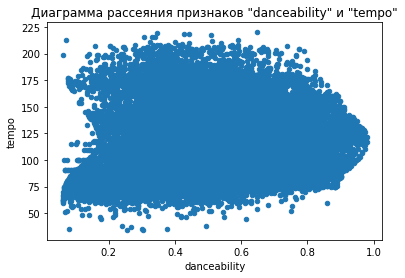

In [154]:
df_train.plot(x='danceability', 
              y='tempo', 
              kind='scatter',
              title='Диаграмма рассеяния признаков "danceability" и "tempo"')
plt.show()